# FinBERT Example Notebook

This notebooks shows how to train and use the FinBERT pre-trained language model for financial sentiment analysis.

## Modules 

In [1]:
from pathlib import Path
import shutil
import os
import logging
import sys
import pandas as pd
sys.path.append('..')

from textblob import TextBlob
from pprint import pprint
from sklearn.metrics import classification_report

from transformers import AutoModelForSequenceClassification

from finbert.finbert import *
import finbert.utils as tools

%load_ext autoreload
%autoreload 2

project_dir = Path.cwd().parent
pd.set_option('max_colwidth', 1)

/Users/pasindusankalpa/Documents/finBERT/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.ERROR)

## Prepare the model

### Setting path variables:
1. `lm_path`: the path for the pre-trained language model (If vanilla Bert is used then no need to set this one).
2. `cl_path`: the path where the classification model is saved.
3. `cl_data_path`: the path of the directory that contains the data files of `train.csv`, `validation.csv`, `test.csv`.
---

In the initialization of `bertmodel`, we can either use the original pre-trained weights from Google by giving `bm = 'bert-base-uncased`, or our further pre-trained language model by `bm = lm_path`


---
All of the configurations with the model is controlled with the `config` variable. 

In [3]:
lm_path = project_dir/'models'/'language_model'/'finbertTRC2'
cl_path = project_dir/'models'/'classifier_model'/'finbert-sentiment'
cl_data_path = project_dir/'data'/'sentiment_data'

In [4]:
# combine train data set
from numpy import negative


train_df_before =  pd.read_csv(
    cl_data_path/'train.csv' , sep="\t",
                index_col=False, 
)
train_df_before.head()

count_df = train_df_before['label'].value_counts().to_dict()
count_df

negative_augmented = pd.read_csv(
    cl_data_path/'augmented_new_negative_df.csv',
    sep="\t",
    encoding="utf-8",
    index_col=False,
)

negative_augmented.head()

negative_augmented['label'].value_counts()

positive_augmented = pd.read_csv(
    cl_data_path/'augmented_new_positive_df.csv',
    sep="\t",
    encoding="utf-8",
    index_col=False,
)

positive_augmented['label'].value_counts()

# neutral_augmented = pd.read_csv(
#     cl_data_path/'augmented_new_neutral_df.csv',
#     sep="\t",
#     encoding="utf-8",
#     index_col=False,
# )

# neutral_augmented['label'].value_counts()

train_df_after = pd.concat([train_df_before, negative_augmented, positive_augmented])

train_df_after['label'].value_counts()

#save the combined data
train_df_after.to_csv(cl_data_path/'train.csv', index=False, sep="\t", encoding="utf-8")

print(train_df_after.shape)
print(train_df_before.shape)

(1896, 2)
(1629, 2)


###  Configuring training parameters

You can find the explanations of the training parameters in the class docsctrings. 

In [5]:
# Clean the cl_path
try:
    shutil.rmtree(cl_path) 
except:
    pass

bertmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert",cache_dir=None, num_labels=3)


config = Config(   data_dir=cl_data_path,
                   bert_model=bertmodel,
                   num_train_epochs=6,
                   model_dir=cl_path,
                   max_seq_length = 64,
                   train_batch_size = 64,
                   learning_rate = 2e-5,
                   output_mode='classification',
                   warm_up_proportion=0.2,
                   local_rank=-1,
                   discriminate=True,
                   gradual_unfreeze=True)

`finbert` is our main class that encapsulates all the functionality. The list of class labels should be given in the prepare_model method call with label_list parameter.

In [6]:
finbert = FinBert(config)
finbert.base_model = 'bert-base-uncased'
finbert.config.discriminate=True
finbert.config.gradual_unfreeze=True

In [7]:
finbert.prepare_model(label_list=['positive','negative','neutral'])

09/14/2025 19:52:43 - INFO - finbert.finbert -   device: cpu n_gpu: 0, distributed training: False, 16-bits training: False


## Fine-tune the model

In [8]:
# Get the training examples
train_data = finbert.get_data('train')

In [9]:
model = finbert.create_the_model()

### [Optional] Fine-tune only a subset of the model
The variable `freeze` determines the last layer (out of 12) to be freezed. You can skip this part if you want to fine-tune the whole model.

<span style="color:red">Important: </span>
Execute this step if you want a shorter training time in the expense of accuracy.

In [10]:
# This is for fine-tuning a subset of the model.

freeze = 6

for param in model.bert.embeddings.parameters():
    param.requires_grad = False
    
for i in range(freeze):
    for param in model.bert.encoder.layer[i].parameters():
        param.requires_grad = False

### Training

In [11]:
trained_model = finbert.train(train_examples = train_data, model = model)

09/14/2025 19:52:45 - INFO - finbert.utils -   *** Example ***
09/14/2025 19:52:45 - INFO - finbert.utils -   guid: train-1
09/14/2025 19:52:45 - INFO - finbert.utils -   tokens: [CLS] 2009 3 february 2010 - finland - based steel maker ra ##uta ##ru ##uk ##ki rt ##rks ) , or ru ##uk ##ki , said today it slipped to a larger - than - expected pre ##ta ##x loss of eu ##r ##46 ##m in the fourth quarter of 2009 from a year - earlier profit of eu ##r ##45 ##m . [SEP]
09/14/2025 19:52:45 - INFO - finbert.utils -   input_ids: 101 2268 1017 2337 2230 1011 6435 1011 2241 3886 9338 10958 13210 6820 6968 3211 19387 19987 1007 1010 2030 21766 6968 3211 1010 2056 2651 2009 5707 2000 1037 3469 1011 2084 1011 3517 3653 2696 2595 3279 1997 7327 2099 21472 2213 1999 1996 2959 4284 1997 2268 2013 1037 2095 1011 3041 5618 1997 7327 2099 19961 2213 1012 102
09/14/2025 19:52:45 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Validation losses: [0.13529823472102484]
No best model found


Iteration: 100%|██████████| 30/30 [00:57<00:00,  1.93s/it]
09/14/2025 19:54:30 - INFO - finbert.utils -   *** Example ***
09/14/2025 19:54:30 - INFO - finbert.utils -   guid: validation-1
09/14/2025 19:54:30 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
09/14/2025 19:54:30 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:54:30 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:54:30 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.13529823472102484, 0.12362139175335567]


Iteration: 100%|██████████| 30/30 [01:12<00:00,  2.43s/it]
09/14/2025 19:55:47 - INFO - finbert.utils -   *** Example ***
09/14/2025 19:55:47 - INFO - finbert.utils -   guid: validation-1
09/14/2025 19:55:47 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
09/14/2025 19:55:47 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:55:47 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:55:47 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.13529823472102484, 0.12362139175335567, 0.10697191456953685]


Iteration: 100%|██████████| 30/30 [01:39<00:00,  3.30s/it]
09/14/2025 19:57:30 - INFO - finbert.utils -   *** Example ***
09/14/2025 19:57:30 - INFO - finbert.utils -   guid: validation-1
09/14/2025 19:57:30 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
09/14/2025 19:57:30 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:57:30 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:57:30 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.13529823472102484, 0.12362139175335567, 0.10697191456953685, 0.10341812173525493]


Iteration: 100%|██████████| 30/30 [02:01<00:00,  4.06s/it]
09/14/2025 19:59:36 - INFO - finbert.utils -   *** Example ***
09/14/2025 19:59:36 - INFO - finbert.utils -   guid: validation-1
09/14/2025 19:59:36 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
09/14/2025 19:59:36 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:59:36 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 19:59:36 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.13529823472102484, 0.12362139175335567, 0.10697191456953685, 0.10341812173525493, 0.09733122090498607]


Iteration: 100%|██████████| 30/30 [01:55<00:00,  3.84s/it]
09/14/2025 20:01:35 - INFO - finbert.utils -   *** Example ***
09/14/2025 20:01:35 - INFO - finbert.utils -   guid: validation-1
09/14/2025 20:01:35 - INFO - finbert.utils -   tokens: [CLS] for the new shares sub ##scribe ##d with stock options all shareholder rights commence from the date on which they are entered into the trade register . [SEP]
09/14/2025 20:01:35 - INFO - finbert.utils -   input_ids: 101 2005 1996 2047 6661 4942 29234 2094 2007 4518 7047 2035 18668 2916 22825 2013 1996 3058 2006 2029 2027 2024 3133 2046 1996 3119 4236 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:35 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:35 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Validation losses: [0.13529823472102484, 0.12362139175335567, 0.10697191456953685, 0.10341812173525493, 0.09733122090498607, 0.09738450994094212]


## Test the model

`bert.evaluate` outputs the DataFrame, where true labels and logit values for each example is given

In [12]:
test_data = finbert.get_data('test')

In [13]:
results = finbert.evaluate(examples=test_data, model=trained_model)

09/14/2025 20:01:40 - INFO - finbert.utils -   *** Example ***
09/14/2025 20:01:40 - INFO - finbert.utils -   guid: test-1
09/14/2025 20:01:40 - INFO - finbert.utils -   tokens: [CLS] card ##ona slowed her vehicle , turned around and returned to the intersection , where she called 911 . [SEP]
09/14/2025 20:01:40 - INFO - finbert.utils -   input_ids: 101 4003 7856 9784 2014 4316 1010 2357 2105 1998 2513 2000 1996 6840 1010 2073 2016 2170 19989 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:40 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:40 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:40 - INFO - finbert.utils -   label: neutral (id = 2)
09/14

Testing: 100%|██████████| 8/8 [00:06<00:00,  1.14it/s]


### Prepare the classification report

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    cs = CrossEntropyLoss(weight=finbert.class_weights)
    loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))
    print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    report, y_true, y_pred = classification_report(df[cols[0]], df[cols[1]])
    print(report)
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.show()


In [15]:
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))

/var/folders/bt/47lhlkx11kd7rvpdmc4zmjh00000gn/T/ipykernel_33956/2059374156.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  loss = cs(torch.tensor(list(df[cols[2]])),torch.tensor(list(df[cols[0]])))


Loss:0.05
Accuracy:0.99

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.98      0.95      0.97        60
           2       1.00      0.99      0.99       276

    accuracy                           0.99       453
   macro avg       0.98      0.98      0.98       453
weighted avg       0.99      0.99      0.99       453



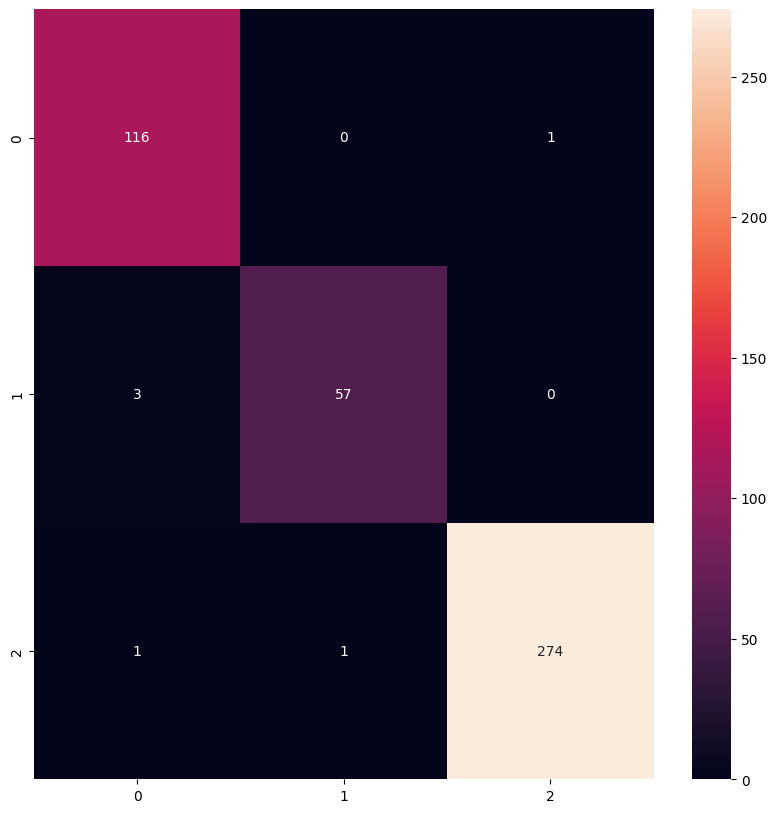

In [16]:
report(results,cols=['labels','prediction','predictions'])



### Get predictions

With the `predict` function, given a piece of text, we split it into a list of sentences and then predict sentiment for each sentence. The output is written into a dataframe. Predictions are represented in three different columns: 

1) `logit`: probabilities for each class

2) `prediction`: predicted label

3) `sentiment_score`: sentiment score calculated as: probability of positive - probability of negative

Below we analyze a paragraph taken out of [this](https://www.economist.com/finance-and-economics/2019/01/03/a-profit-warning-from-apple-jolts-markets) article from The Economist. For comparison purposes, we also put the sentiments predicted with TextBlob.
> Later that day Apple said it was revising down its earnings expectations in the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China. The news rapidly infected financial markets. Apple’s share price fell by around 7% in after-hours trading and the decline was extended to more than 10% when the market opened. The dollar fell by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering some ground. Asian stockmarkets closed down on January 3rd and European ones opened lower. Yields on government bonds fell as investors fled to the traditional haven in a market storm.

In [17]:
# text = "Later that day Apple said it was revising down its earnings expectations in \
# the fourth quarter of 2018, largely because of lower sales and signs of economic weakness in China. \
# The news rapidly infected financial markets. Apple’s share price fell by around 7% in after-hours \
# trading and the decline was extended to more than 10% when the market opened. The dollar fell \
# by 3.7% against the yen in a matter of minutes after the announcement, before rapidly recovering \
# some ground. Asian stockmarkets closed down on January 3rd and European ones opened lower. \
# Yields on government bonds fell as investors fled to the traditional haven in a market storm."

Evaluate Exisiting FinBert

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", cache_dir=None, num_labels=3)

In [19]:
test_data = finbert.get_data('test')

In [20]:
results = finbert.evaluate(examples=test_data, model=model)

09/14/2025 20:01:48 - INFO - finbert.utils -   *** Example ***
09/14/2025 20:01:48 - INFO - finbert.utils -   guid: test-1
09/14/2025 20:01:48 - INFO - finbert.utils -   tokens: [CLS] card ##ona slowed her vehicle , turned around and returned to the intersection , where she called 911 . [SEP]
09/14/2025 20:01:48 - INFO - finbert.utils -   input_ids: 101 4003 7856 9784 2014 4316 1010 2357 2105 1998 2513 2000 1996 6840 1010 2073 2016 2170 19989 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:48 - INFO - finbert.utils -   attention_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
09/14/2025 20:01:48 - INFO - finbert.utils -   token_type_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


09/14/2025 20:01:48 - INFO - finbert.utils -   label: neutral (id = 2)
09/14/2025 20:01:48 - INFO - finbert.finbert -   ***** Loading data *****
09/14/2025 20:01:48 - INFO - finbert.finbert -     Num examples = 453
09/14/2025 20:01:48 - INFO - finbert.finbert -     Batch size = 64
09/14/2025 20:01:48 - INFO - finbert.finbert -     Num steps = 42
09/14/2025 20:01:48 - INFO - finbert.finbert -   ***** Running evaluation ***** 
09/14/2025 20:01:48 - INFO - finbert.finbert -     Num examples = 453
09/14/2025 20:01:48 - INFO - finbert.finbert -     Batch size = 32
Testing: 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


Accuracy:0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       117
           1       0.94      1.00      0.97        60
           2       1.00      0.97      0.99       276

    accuracy                           0.98       453
   macro avg       0.97      0.99      0.98       453
weighted avg       0.98      0.98      0.98       453



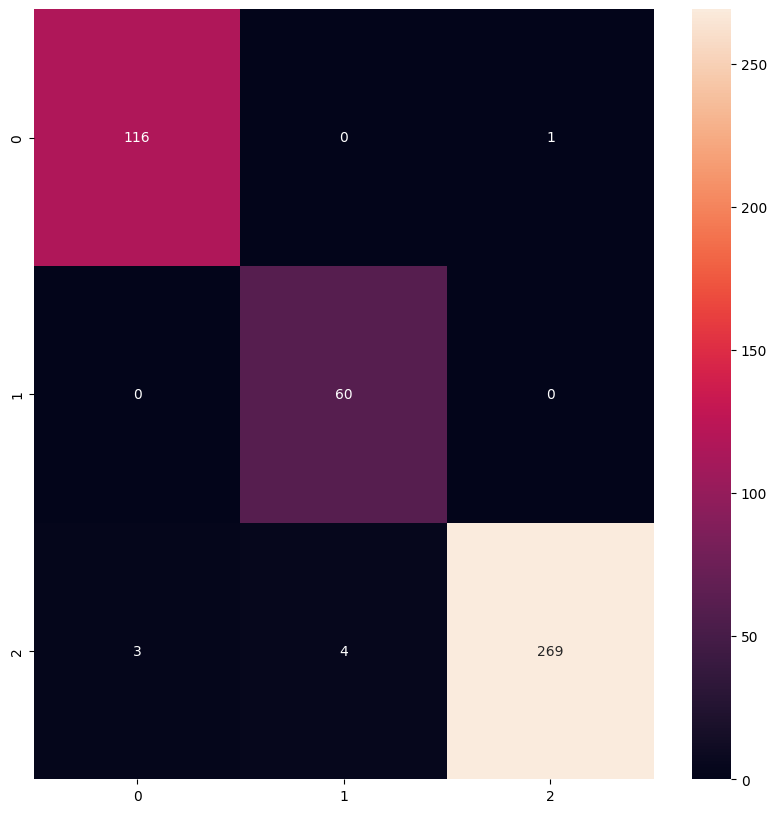

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def report(df, cols=['label','prediction','logits']):
    #print('Validation loss:{0:.2f}'.format(metrics['best_validation_loss']))
    # cs = CrossEntropyLoss(weight=model.class_weights)
    # print("Loss:{0:.2f}".format(loss))
    print("Accuracy:{0:.2f}".format((df[cols[0]] == df[cols[1]]).sum() / df.shape[0]) )
    print("\nClassification Report:")
    report, y_true, y_pred = classification_report(df[cols[0]], df[cols[1]])
    print(report)
    plt.figure(figsize=(10, 10))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')
    plt.show()
    
results['prediction'] = results.predictions.apply(lambda x: np.argmax(x,axis=0))
report(results,cols=['labels','prediction','predictions'])






In [22]:
# results

In [23]:
# confusion matrix with results





In [24]:
# cl_path = project_dir/'models'/'classifier_model'/'finbert-sentiment'
# model = AutoModelForSequenceClassification.from_pretrained(cl_path, cache_dir=None, num_labels=3)

In [25]:
# import nltk
# nltk.download('punkt')

In [26]:
# result = predict(text,model)

In [27]:
# blob = TextBlob(text)
# result['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]
# result

In [28]:
# print(f'Average sentiment is %.2f.' % (result.sentiment_score.mean()))

Here is another example

In [29]:
# text2 = "Shares in the spin-off of South African e-commerce group Naspers surged more than 25% \
# in the first minutes of their market debut in Amsterdam on Wednesday. Bob van Dijk, CEO of \
# Naspers and Prosus Group poses at Amsterdam's stock exchange, as Prosus begins trading on the \
# Euronext stock exchange in Amsterdam, Netherlands, September 11, 2019. REUTERS/Piroschka van de Wouw \
# Prosus comprises Naspers’ global empire of consumer internet assets, with the jewel in the crown a \
# 31% stake in Chinese tech titan Tencent. There is 'way more demand than is even available, so that’s \
# good,' said the CEO of Euronext Amsterdam, Maurice van Tilburg. 'It’s going to be an interesting \
# hour of trade after opening this morning.' Euronext had given an indicative price of 58.70 euros \
# per share for Prosus, implying a market value of 95.3 billion euros ($105 billion). The shares \
# jumped to 76 euros on opening and were trading at 75 euros at 0719 GMT."

In [30]:
# result2 = predict(text2,model)
# blob = TextBlob(text2)
# result2['textblob_prediction'] = [sentence.sentiment.polarity for sentence in blob.sentences]

In [31]:
# result2

In [32]:
# print(f'Average sentiment is %.2f.' % (result2.sentiment_score.mean()))